In [2]:
pip install pmdarima


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.4 MB/s eta 0:00:00


ARIMA Model after resolving the user warning

ADF Statistic: -0.583072505808776
p-value: 0.8747612556281332
Data is non-stationary, applying differencing...


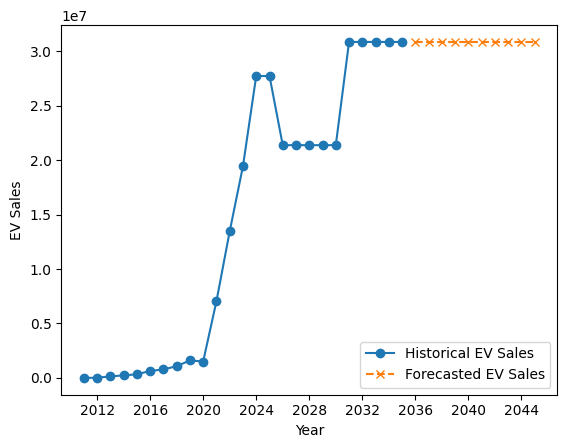

In [26]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
data = pd.read_csv('IEA Global EV Data 2024.csv')

# Filter for relevant data (e.g., global EV sales)
ev_sales = data[(data['parameter'] == 'EV sales') & (data['powertrain'].isin(['EV', 'PHEV']))]

# Group by year to aggregate the sales
sales_by_year = ev_sales.groupby('year')['value'].sum()

# Convert the year index to DatetimeIndex for proper handling by ARIMA
sales_by_year.index = pd.to_datetime(sales_by_year.index, format='%Y')

# Ensure the index has a yearly frequency and fill missing years if necessary
sales_by_year = sales_by_year.asfreq('Y', method='pad')  # Forward fill any missing years

# Check if sales_by_year is empty
if sales_by_year.empty:
    print("Error: No data available for ARIMA model fitting.")
else:
    # ADF Test to check for stationarity
    result = adfuller(sales_by_year)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')

    # If p-value > 0.05, data is non-stationary, apply differencing
    if result[1] > 0.05:
        print("Data is non-stationary, applying differencing...")
        sales_by_year_diff = sales_by_year.diff().dropna()  # Differencing

        # Fit a simplified ARIMA model on differenced data
        model = ARIMA(sales_by_year_diff, order=(1, 1, 0))  # Simple ARIMA
        model_fit = model.fit()

        # Forecast future EV sales (next 10 years)
        forecast_diff = model_fit.forecast(steps=10)

        # Undo the differencing to get the actual forecast
        forecast = sales_by_year.iloc[-1] + forecast_diff.cumsum()
    else:
        # Fit ARIMA model directly if data is stationary
        model = ARIMA(sales_by_year, order=(1, 1, 0))  # Simple ARIMA
        model_fit = model.fit()

        # Forecast future EV sales (next 10 years)
        forecast = model_fit.forecast(steps=10)

    # Create future years for plotting
    future_years = pd.date_range(start=sales_by_year.index[-1], periods=11, freq='Y')[1:]

    # Plot actual vs forecast
    plt.plot(sales_by_year.index, sales_by_year, label='Historical EV Sales', marker='o')
    plt.plot(future_years, forecast, label='Forecasted EV Sales', linestyle='--', marker='x')
    plt.xlabel('Year')
    plt.ylabel('EV Sales')
    plt.legend()
    plt.show()


1. Evaluate Model Performance
To assess how well the ARIMA model performed,let us use RMSE or MAE.

  Code for RMSE and MAE Evaluation:

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Assuming you have your actual data for the forecasted period for comparison
# For now, we'll use the last 10 years of your historical data as a proxy

# Define the training period (historical data up to the last 10 years)
train_size = len(sales_by_year) - 10
train_data = sales_by_year[:train_size]
test_data = sales_by_year[train_size:]

# Fit the ARIMA model on the training data
model = ARIMA(train_data, order=(1, 1, 0))  # Using the same ARIMA order as before
model_fit = model.fit()

# Forecast the test period (next 10 years)
forecast_test = model_fit.forecast(steps=10)

# Calculate RMSE and MAE between the actual test data and forecast
rmse = np.sqrt(mean_squared_error(test_data, forecast_test))
mae = mean_absolute_error(test_data, forecast_test)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')


RMSE: 5005443.271657616
MAE: 4739316.5


I have also considered a more complex ARIMA model for evaluation.

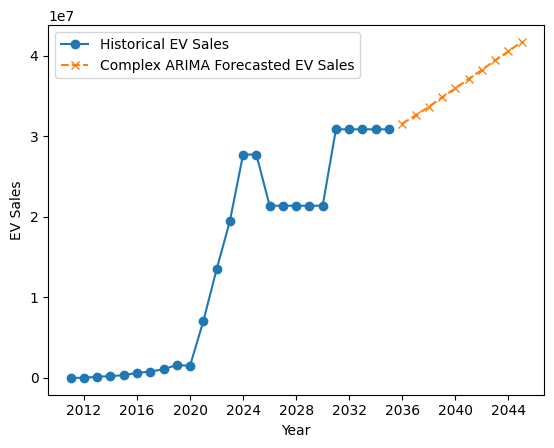

In [28]:
# Fit a more complex ARIMA model
model = ARIMA(sales_by_year_diff, order=(2, 1, 2))  # Trying ARIMA(2,1,2)
model_fit = model.fit()

# Forecast future EV sales (next 10 years)
forecast_diff = model_fit.forecast(steps=10)

# Undo the differencing to get the actual forecast
forecast = sales_by_year.iloc[-1] + forecast_diff.cumsum()

# Create future years for plotting
future_years = pd.date_range(start=sales_by_year.index[-1], periods=11, freq='Y')[1:]

# Plot actual vs forecast
plt.plot(sales_by_year.index, sales_by_year, label='Historical EV Sales', marker='o')
plt.plot(future_years, forecast, label='Complex ARIMA Forecasted EV Sales', linestyle='--', marker='x')
plt.xlabel('Year')
plt.ylabel('EV Sales')
plt.legend()
plt.show()


Inorder to analyze seasonal patterns in data, I have used SARIMA as well

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


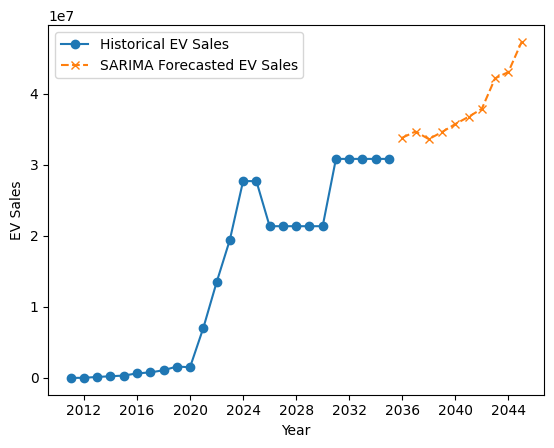

In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit a SARIMA model with seasonal components
model_sarima = SARIMAX(sales_by_year_diff, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = model_sarima.fit()

# Forecast using the SARIMA model
forecast_sarima = sarima_fit.forecast(steps=10)

# Undo the differencing to get the actual forecast
forecast = sales_by_year.iloc[-1] + forecast_sarima.cumsum()

# Create future years for plotting
future_years = pd.date_range(start=sales_by_year.index[-1], periods=11, freq='Y')[1:]

# Plot actual vs forecast
plt.plot(sales_by_year.index, sales_by_year, label='Historical EV Sales', marker='o')
plt.plot(future_years, forecast, label='SARIMA Forecasted EV Sales', linestyle='--', marker='x')
plt.xlabel('Year')
plt.ylabel('EV Sales')
plt.legend()
plt.show()


Plotting Differenced Data

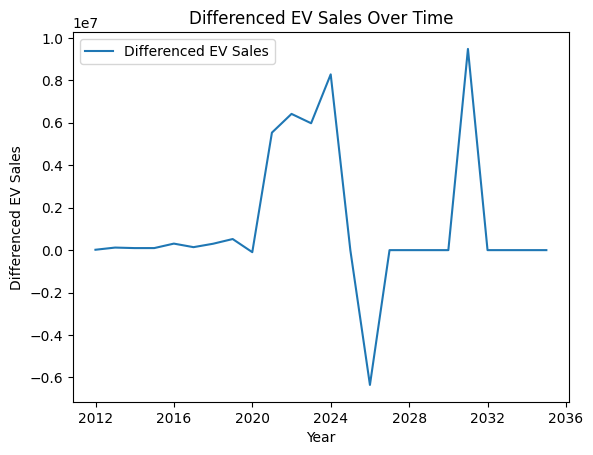

In [30]:
# Plot the differenced data
plt.plot(sales_by_year_diff.index, sales_by_year_diff, label='Differenced EV Sales')
plt.xlabel('Year')
plt.ylabel('Differenced EV Sales')
plt.title('Differenced EV Sales Over Time')
plt.legend()
plt.show()


Updated changes as per review

In [31]:
# Set the 'year' column as DatetimeIndex
sales_by_year.index = pd.to_datetime(sales_by_year.index, format='%Y')

# Ensure the index has a yearly frequency
sales_by_year = sales_by_year.asfreq('Y')


Experimenting with ARIMA Model Parameters (p, d, q)
Auto ARIMA


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=797.816, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=793.089, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=792.647, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=792.672, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=794.430, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=794.345, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=794.647, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=796.592, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=792.219, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=794.224, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=794.503, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=792.814, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=796.493, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.768 seconds


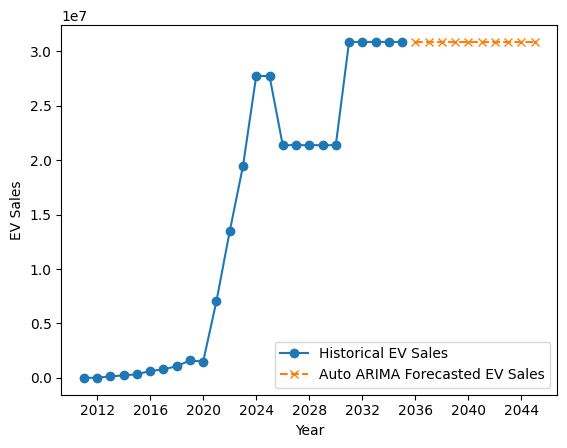

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   25
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -394.109
Date:                Sun, 22 Sep 2024   AIC                            792.219
Time:                        10:32:34   BIC                            794.575
Sample:                    12-31-2010   HQIC                           792.844
                         - 12-31-2034                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4012      0.166      2.423      0.015       0.077       0.726
sigma2      1.119e+13   1.51e-15   7.42e+27      0.000    1.12e+13    1.12e+13
Ljung-Box (L1) (Q):                   0.04   Jarque-

In [33]:
import pmdarima as pm
import matplotlib.pyplot as plt
import pandas as pd

# Auto-ARIMA model to find the best (p, d, q) values
auto_model = pm.auto_arima(sales_by_year, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the best ARIMA model found by auto_arima
auto_model_fit = auto_model.fit(sales_by_year)

# Forecast future EV sales (next 10 years)
forecast_auto_arima = auto_model_fit.predict(n_periods=10)

# Plot historical vs forecast
future_years = pd.date_range(start=sales_by_year.index[-1], periods=11, freq='Y')[1:]
plt.plot(sales_by_year.index, sales_by_year, label='Historical EV Sales', marker='o')
plt.plot(future_years, forecast_auto_arima, label='Auto ARIMA Forecasted EV Sales', linestyle='--', marker='x')
plt.xlabel('Year')
plt.ylabel('EV Sales')
plt.legend()
plt.show()

# Print the best ARIMA model chosen by auto_arima
print(auto_model.summary())


The forecasted sales appear flat based on the plot, which means the model is predicting a steady level of EV sales growth without any significant increase or decrease after 2035.
Best ARIMA Model: The best model chosen was ARIMA(1,1,0), meaning:

p=1: The autoregressive term includes one lag of the dependent variable.
d=1: The data was differenced once to make it stationary.
q=0: No moving average terms are included in the model.
AIC (Akaike Information Criterion): The AIC score for the best model is 792.219, which was lower than other models tested, making this model the best based on AIC.